In [ ]:
!pip install hmmlearn mplfinance

In [2]:
from datetime import datetime
import numpy as np
from hmmlearn.hmm import GaussianHMM
import pandas as pd
from mplfinance.original_flavor import candlestick_ochl
from matplotlib.dates import date2num, YearLocator, DateFormatter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 读取数据
def convert_amount(x):
    if x[-1] == 'B':
        return float(x[:-1]) * 1e9
    elif x[-1] == 'M':
        return float(x[:-1]) * 1e6
    elif x[-1] == 'K':
        return float(x[:-1]) * 1e3
    else:
        raise Exception()
    
data = pd.read_csv('./stock_data.csv', thousands=',')
data['amount'] = data['amount'].apply(convert_amount)
data['date'] = data['date'].apply(pd.to_datetime)
data

,date,close_price,open_price,high,low,amount,diff_ratio
0,2023-11-28,3038.55,3028.60,3039.69,3020.23,2.689000e+10,0.23%
1,2023-11-27,3031.70,3038.19,3038.36,3015.01,3.105000e+10,-0.30%
2,2023-11-24,3040.97,3060.33,3060.33,3037.20,2.878000e+10,-0.68%
3,2023-11-23,3061.86,3041.68,3062.87,3034.30,2.766000e+10,0.60%
4,2023-11-22,3043.61,3060.50,3067.96,3043.61,2.891000e+10,-0.79%
...,...,...,...,...,...,...,...
4590,2005-01-10,1252.40,1243.58,1252.72,1236.09,7.235000e+08,0.61%
4591,2005-01-07,1244.75,1239.32,1256.31,1235.51,8.941000e+08,0.43%
4592,2005-01-06,1239.43,1252.49,1252.73,1234.24,7.922000e+08,-1.00%
4593,2005-01-05,1251.94,1241.68,1258.58,1235.75,8.679000e+08,0.74%


In [4]:
data['a_5'] = np.log(data['amount']).diff(-5)
data['a_20'] = np.log(data['amount']).diff(-20)
data['r_5'] = np.log(data['close_price']).diff(-5)
data['r_20'] = np.log(data['close_price']).diff(-20)
data['date2num'] = data['date'].apply(lambda x: date2num(x))
data = data[data['date'] >= '2005-06-01']
data

,date,close_price,open_price,high,low,amount,diff_ratio,a_5,a_20,r_5,r_20,date2num
0,2023-11-28,3038.55,3028.60,3039.69,3020.23,2.689000e+10,0.23%,-0.206872,-0.173669,-0.009623,0.006531,19689.0
1,2023-11-27,3031.70,3038.19,3038.36,3015.01,3.105000e+10,-0.30%,0.076613,-0.149585,-0.012007,0.003354,19688.0
2,2023-11-24,3040.97,3060.33,3060.33,3037.20,2.878000e+10,-0.68%,0.072772,-0.111664,-0.004397,0.007655,19685.0
3,2023-11-23,3061.86,3041.68,3062.87,3034.30,2.766000e+10,0.60%,0.020085,-0.053496,0.003576,0.024318,19684.0
4,2023-11-22,3043.61,3060.50,3067.96,3043.61,2.891000e+10,-0.79%,-0.050913,-0.139566,-0.009555,0.023099,19683.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4496,2005-06-07,1030.94,1036.62,1055.63,1029.54,1.570000e+09,-0.33%,0.530227,0.173444,-0.028496,-0.096655,12941.0
4497,2005-06-06,1034.38,1010.38,1034.85,998.23,1.100000e+09,2.05%,0.246133,0.009132,-0.024618,-0.089159,12940.0
4498,2005-06-03,1013.64,1013.90,1019.92,1000.52,1.000000e+09,-0.24%,-0.009950,-0.343590,-0.037098,-0.134139,12937.0
4499,2005-06-02,1016.06,1036.73,1036.73,1008.75,1.150000e+09,-2.23%,0.191161,-0.414123,-0.041270,-0.140319,12936.0


In [5]:
cols = ['r_5', 'r_20', 'a_5', 'a_20']
model = GaussianHMM(n_components=3, covariance_type='full',
                    n_iter=1000, random_state=1024)
model.fit(data[cols])
hidden_status = model.predict(data[cols])

In [6]:
def draw_data(ax, _data):
    '''
    使用柱状图表示股市数据
    '''
    candlestick_ochl(ax, _data[['date2num', 'open_price',
                                'close_price', 'high', 'low']].values,
                     colorup='r', colordown='g', width=0.5)
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    return ax

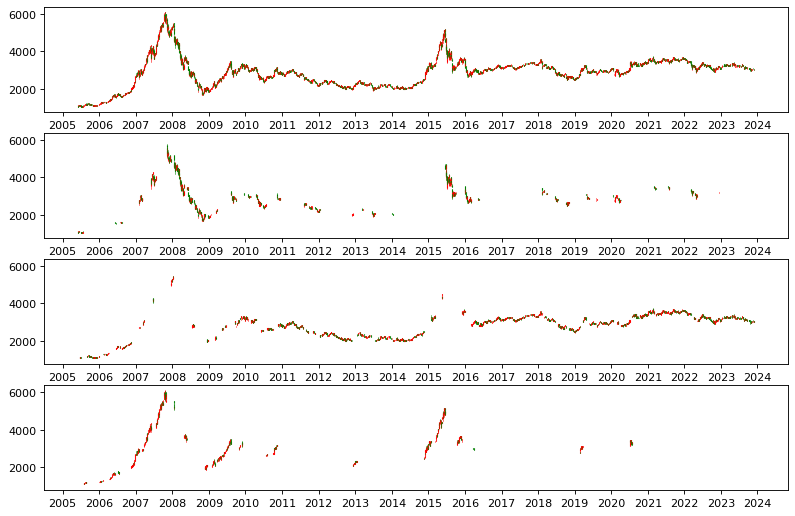

In [7]:
# 创建一个图形框
fig = plt.figure(figsize=(12, 8), dpi=80)
ax0 = fig.add_subplot(4, 1, 1)
draw_data(ax0, data)
for i in range(max(hidden_status)+1):
    _data = data[hidden_status == i]
    ax = fig.add_subplot(4, 1, i + 2, sharex=ax0, sharey=ax0)
    draw_data(ax, _data)
plt.savefig('stock_analysis.png', dpi=200)
plt.show()